# Train and Test Deep Learning Model
This notebook loads the dataset generated by generate_dataset.py and the deep learning model from model.py.
It then trains and tests the model.

In [1]:
# Import
from model import ResDenseNet
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
from tqdm import tqdm


In [2]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/CY/" # Change this to your storage directory
dataset_dir = local_storage_dir + "Datasets/GKZ/"
checkpoint_dir = local_storage_dir + "Checkpoints/"
log_dir = local_storage_dir + "Logs/"
train_features_path = dataset_dir + "train_features.csv"
train_labels_path = dataset_dir + "train_labels.csv"
test_features_path = dataset_dir + "test_features.csv"
test_labels_path = dataset_dir + "test_labels.csv"

# Create directories
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

batch_size = 2**10
validation_split = 0.2 # 20% of the training data is used for validation

In [3]:
# Load Dataset
class GKZDataset(Dataset):
    def __init__(self, features_path, labels_path):
        self.features = pd.read_csv(features_path, header=None).astype('float32')
        self.labels = pd.read_csv(labels_path, header=None).astype('float32')
        assert len(self.features) == len(self.labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx].values), torch.tensor(self.labels.iloc[idx].values)
    
# Create Dataset
train_dataset = GKZDataset(train_features_path, train_labels_path)
validation_size = int(validation_split * len(train_dataset))
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])
test_dataset = GKZDataset(test_features_path, test_labels_path)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

# Set input size
input_size = len(train_dataset[0][0])

In [4]:
# Create Model
model = ResDenseNet(input_size=input_size, width=1024, depth=8, dropout=0.2).to(device)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

# Create Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995, last_epoch=-1, verbose=False)

# Create Loss Function
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)


Number of parameters:  8433673


In [5]:
# Training
epochs = 250
checkpoint_interval = 5
model.train()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(log_dir=log_dir+timestamp)

num_batches = len(train_loader)
for epoch in range(1, epochs+1):
    epoch_loss = 0
    min_loss = 100000
    with tqdm(train_loader, total=num_batches) as pbar:
        for b,batch in enumerate(pbar):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            predictions = model(features)
            loss = loss_fn(labels, predictions)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix({"Epoch:": epoch,
                                       "LR:":optimizer.param_groups[0]['lr'],
                                         "Loss:": epoch_loss/(b+1)})
    epoch_loss = epoch_loss/num_batches
    with torch.no_grad():
        model.eval()
        validation_loss = 0
        for b,batch in enumerate(validation_loader):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)
            loss = loss_fn(labels, predictions)
            validation_loss += loss.item()
        validation_loss = validation_loss/len(validation_loader)
        model.train()
    if lr_scheduler is not None:
        lr_scheduler.step()
    if checkpoint_dir is not None:
        checkpoint_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': lr_scheduler.state_dict(),
            'loss': loss
        }
        if validation_loss < min_loss:
            min_loss = validation_loss
            torch.save(checkpoint_dict, os.path.join(checkpoint_dir,
                                                        "model_min_loss.pt"))
            
    writer.add_scalars("Loss", {"Training Loss": epoch_loss, "Validation Loss": validation_loss}, epoch)
    print("Epoch: {} Training Loss: {} Validation Loss: {}".format(epoch, epoch_loss, validation_loss))
    print("LR: {}".format(optimizer.param_groups[0]['lr']))
writer.close()

100%|██████████| 1205/1205 [00:08<00:00, 134.93it/s, Epoch:=1, LR:=0.001, Loss:=0.658]


Epoch: 1 Training Loss: 0.6584817097518454 Validation Loss: 0.1608573633017919
LR: 0.000995


100%|██████████| 1205/1205 [00:08<00:00, 143.68it/s, Epoch:=2, LR:=0.000995, Loss:=0.148]


Epoch: 2 Training Loss: 0.147682820631508 Validation Loss: 0.1354761290431812
LR: 0.000990025


100%|██████████| 1205/1205 [00:07<00:00, 151.15it/s, Epoch:=3, LR:=0.00099, Loss:=0.126]


Epoch: 3 Training Loss: 0.12611165238984887 Validation Loss: 0.12191072506028296
LR: 0.000985074875


100%|██████████| 1205/1205 [00:08<00:00, 147.54it/s, Epoch:=4, LR:=0.000985, Loss:=0.114]


Epoch: 4 Training Loss: 0.11380053885992138 Validation Loss: 0.10483830619529383
LR: 0.000980149500625


100%|██████████| 1205/1205 [00:08<00:00, 147.11it/s, Epoch:=5, LR:=0.00098, Loss:=0.106]


Epoch: 5 Training Loss: 0.10631092323678164 Validation Loss: 0.09732336768054015
LR: 0.000975248753121875


100%|██████████| 1205/1205 [00:08<00:00, 146.38it/s, Epoch:=6, LR:=0.000975, Loss:=0.1]  


Epoch: 6 Training Loss: 0.1001808552882978 Validation Loss: 0.09420654826507663
LR: 0.0009703725093562657


100%|██████████| 1205/1205 [00:08<00:00, 144.34it/s, Epoch:=7, LR:=0.00097, Loss:=0.0958]


Epoch: 7 Training Loss: 0.09582601631701734 Validation Loss: 0.09161753752669752
LR: 0.0009655206468094843


100%|██████████| 1205/1205 [00:08<00:00, 147.13it/s, Epoch:=8, LR:=0.000966, Loss:=0.0913]


Epoch: 8 Training Loss: 0.09127804570178273 Validation Loss: 0.08809901734456321
LR: 0.0009606930435754369


100%|██████████| 1205/1205 [00:08<00:00, 148.28it/s, Epoch:=9, LR:=0.000961, Loss:=0.0877]


Epoch: 9 Training Loss: 0.08772740322648243 Validation Loss: 0.09122670930347695
LR: 0.0009558895783575597


100%|██████████| 1205/1205 [00:08<00:00, 146.31it/s, Epoch:=10, LR:=0.000956, Loss:=0.0859]


Epoch: 10 Training Loss: 0.08585271980010623 Validation Loss: 0.08098208825319808
LR: 0.0009511101304657719


100%|██████████| 1205/1205 [00:08<00:00, 147.03it/s, Epoch:=11, LR:=0.000951, Loss:=0.0827]


Epoch: 11 Training Loss: 0.08268170223814818 Validation Loss: 0.07697918423951067
LR: 0.000946354579813443


100%|██████████| 1205/1205 [00:08<00:00, 146.19it/s, Epoch:=12, LR:=0.000946, Loss:=0.0808]


Epoch: 12 Training Loss: 0.08080405529851241 Validation Loss: 0.08478876390796623
LR: 0.0009416228069143757


100%|██████████| 1205/1205 [00:08<00:00, 148.92it/s, Epoch:=13, LR:=0.000942, Loss:=0.0788]


Epoch: 13 Training Loss: 0.07877781638465976 Validation Loss: 0.07359841426476738
LR: 0.0009369146928798038


100%|██████████| 1205/1205 [00:08<00:00, 146.73it/s, Epoch:=14, LR:=0.000937, Loss:=0.077] 


Epoch: 14 Training Loss: 0.07697097780917195 Validation Loss: 0.07221951767407506
LR: 0.0009322301194154048


100%|██████████| 1205/1205 [00:07<00:00, 152.54it/s, Epoch:=15, LR:=0.000932, Loss:=0.0756]


Epoch: 15 Training Loss: 0.07564588959533644 Validation Loss: 0.08244253053570426
LR: 0.0009275689688183278


100%|██████████| 1205/1205 [00:08<00:00, 148.25it/s, Epoch:=16, LR:=0.000928, Loss:=0.0742]


Epoch: 16 Training Loss: 0.07419346386713606 Validation Loss: 0.08059464708365352
LR: 0.0009229311239742361


100%|██████████| 1205/1205 [00:08<00:00, 149.89it/s, Epoch:=17, LR:=0.000923, Loss:=0.0722]


Epoch: 17 Training Loss: 0.0721500001631337 Validation Loss: 0.07278621806115504
LR: 0.0009183164683543649


100%|██████████| 1205/1205 [00:08<00:00, 147.94it/s, Epoch:=18, LR:=0.000918, Loss:=0.0717]


Epoch: 18 Training Loss: 0.0716775916300374 Validation Loss: 0.06960819308824887
LR: 0.0009137248860125931


100%|██████████| 1205/1205 [00:08<00:00, 148.86it/s, Epoch:=19, LR:=0.000914, Loss:=0.0705]


Epoch: 19 Training Loss: 0.07047036335923365 Validation Loss: 0.06619200111669025
LR: 0.0009091562615825302


100%|██████████| 1205/1205 [00:08<00:00, 146.72it/s, Epoch:=20, LR:=0.000909, Loss:=0.0692]


Epoch: 20 Training Loss: 0.06923972413685807 Validation Loss: 0.06875206312991136
LR: 0.0009046104802746175


100%|██████████| 1205/1205 [00:08<00:00, 148.26it/s, Epoch:=21, LR:=0.000905, Loss:=0.0683]


Epoch: 21 Training Loss: 0.06827679619316739 Validation Loss: 0.06620579578031767
LR: 0.0009000874278732445


100%|██████████| 1205/1205 [00:08<00:00, 144.64it/s, Epoch:=22, LR:=0.0009, Loss:=0.0674]


Epoch: 22 Training Loss: 0.06740841293607015 Validation Loss: 0.07912496669797708
LR: 0.0008955869907338783


100%|██████████| 1205/1205 [00:08<00:00, 143.45it/s, Epoch:=23, LR:=0.000896, Loss:=0.0665]


Epoch: 23 Training Loss: 0.06646731891881875 Validation Loss: 0.06486582279896104
LR: 0.0008911090557802089


100%|██████████| 1205/1205 [00:08<00:00, 146.88it/s, Epoch:=24, LR:=0.000891, Loss:=0.0654]


Epoch: 24 Training Loss: 0.06537299702770977 Validation Loss: 0.06752811213153483
LR: 0.0008866535105013078


100%|██████████| 1205/1205 [00:08<00:00, 147.99it/s, Epoch:=25, LR:=0.000887, Loss:=0.065] 


Epoch: 25 Training Loss: 0.06500146099331468 Validation Loss: 0.06841301013845087
LR: 0.0008822202429488013


100%|██████████| 1205/1205 [00:08<00:00, 147.11it/s, Epoch:=26, LR:=0.000882, Loss:=0.0638]


Epoch: 26 Training Loss: 0.06378393238758151 Validation Loss: 0.06254417917981053
LR: 0.0008778091417340573


100%|██████████| 1205/1205 [00:08<00:00, 144.87it/s, Epoch:=27, LR:=0.000878, Loss:=0.0635]


Epoch: 27 Training Loss: 0.0635231505878486 Validation Loss: 0.0624330598022172
LR: 0.000873420096025387


100%|██████████| 1205/1205 [00:08<00:00, 147.64it/s, Epoch:=28, LR:=0.000873, Loss:=0.0626]


Epoch: 28 Training Loss: 0.06257122625824821 Validation Loss: 0.06621424176588359
LR: 0.0008690529955452601


100%|██████████| 1205/1205 [00:08<00:00, 147.81it/s, Epoch:=29, LR:=0.000869, Loss:=0.0617]


Epoch: 29 Training Loss: 0.061657618737443354 Validation Loss: 0.06685234997298149
LR: 0.0008647077305675338


100%|██████████| 1205/1205 [00:08<00:00, 148.66it/s, Epoch:=30, LR:=0.000865, Loss:=0.0611]


Epoch: 30 Training Loss: 0.061059299364871505 Validation Loss: 0.060403581782682056
LR: 0.0008603841919146961


100%|██████████| 1205/1205 [00:08<00:00, 144.00it/s, Epoch:=31, LR:=0.00086, Loss:=0.0607]


Epoch: 31 Training Loss: 0.06074996214684609 Validation Loss: 0.06109596216520726
LR: 0.0008560822709551226


100%|██████████| 1205/1205 [00:08<00:00, 146.78it/s, Epoch:=32, LR:=0.000856, Loss:=0.0601]


Epoch: 32 Training Loss: 0.06013920449369676 Validation Loss: 0.06027670281118905
LR: 0.000851801859600347


100%|██████████| 1205/1205 [00:08<00:00, 150.44it/s, Epoch:=33, LR:=0.000852, Loss:=0.0594]


Epoch: 33 Training Loss: 0.059402320496892536 Validation Loss: 0.05832971219244777
LR: 0.0008475428503023452


100%|██████████| 1205/1205 [00:08<00:00, 144.81it/s, Epoch:=34, LR:=0.000848, Loss:=0.0587]


Epoch: 34 Training Loss: 0.05874490271403582 Validation Loss: 0.0636450792261899
LR: 0.0008433051360508335


100%|██████████| 1205/1205 [00:08<00:00, 144.47it/s, Epoch:=35, LR:=0.000843, Loss:=0.0582]


Epoch: 35 Training Loss: 0.05822691691428794 Validation Loss: 0.057132758829273926
LR: 0.0008390886103705794


100%|██████████| 1205/1205 [00:08<00:00, 144.66it/s, Epoch:=36, LR:=0.000839, Loss:=0.0577]


Epoch: 36 Training Loss: 0.05772867622279033 Validation Loss: 0.05840196768870417
LR: 0.0008348931673187264


100%|██████████| 1205/1205 [00:08<00:00, 147.48it/s, Epoch:=37, LR:=0.000835, Loss:=0.0573]


Epoch: 37 Training Loss: 0.057330804129606464 Validation Loss: 0.05789807056453054
LR: 0.0008307187014821328


100%|██████████| 1205/1205 [00:08<00:00, 147.85it/s, Epoch:=38, LR:=0.000831, Loss:=0.0569]


Epoch: 38 Training Loss: 0.056896856328263815 Validation Loss: 0.056033485525885954
LR: 0.0008265651079747222


100%|██████████| 1205/1205 [00:08<00:00, 149.12it/s, Epoch:=39, LR:=0.000827, Loss:=0.0564]


Epoch: 39 Training Loss: 0.05639919006107259 Validation Loss: 0.05513066631920685
LR: 0.0008224322824348485


100%|██████████| 1205/1205 [00:08<00:00, 146.53it/s, Epoch:=40, LR:=0.000822, Loss:=0.0559]


Epoch: 40 Training Loss: 0.055861091709606875 Validation Loss: 0.05803096903771754
LR: 0.0008183201210226743


100%|██████████| 1205/1205 [00:08<00:00, 150.50it/s, Epoch:=41, LR:=0.000818, Loss:=0.0554]


Epoch: 41 Training Loss: 0.0554182206663106 Validation Loss: 0.055417804220160904
LR: 0.0008142285204175609


100%|██████████| 1205/1205 [00:07<00:00, 151.83it/s, Epoch:=42, LR:=0.000814, Loss:=0.0549]


Epoch: 42 Training Loss: 0.05492594934907197 Validation Loss: 0.05369078070665432
LR: 0.0008101573778154731


100%|██████████| 1205/1205 [00:08<00:00, 147.66it/s, Epoch:=43, LR:=0.00081, Loss:=0.0545]


Epoch: 43 Training Loss: 0.05446218662427669 Validation Loss: 0.05789978909522098
LR: 0.0008061065909263957


100%|██████████| 1205/1205 [00:08<00:00, 144.42it/s, Epoch:=44, LR:=0.000806, Loss:=0.0545]


Epoch: 44 Training Loss: 0.054483217473964965 Validation Loss: 0.05668910405296364
LR: 0.0008020760579717638


100%|██████████| 1205/1205 [00:08<00:00, 145.34it/s, Epoch:=45, LR:=0.000802, Loss:=0.0535]


Epoch: 45 Training Loss: 0.053530906394309526 Validation Loss: 0.0537147524193028
LR: 0.000798065677681905


100%|██████████| 1205/1205 [00:08<00:00, 148.79it/s, Epoch:=46, LR:=0.000798, Loss:=0.0535]


Epoch: 46 Training Loss: 0.05352103386800813 Validation Loss: 0.052920176197361474
LR: 0.0007940753492934955


100%|██████████| 1205/1205 [00:08<00:00, 148.32it/s, Epoch:=47, LR:=0.000794, Loss:=0.0529]


Epoch: 47 Training Loss: 0.05287300684330869 Validation Loss: 0.05223367611156
LR: 0.000790104972547028


100%|██████████| 1205/1205 [00:08<00:00, 147.82it/s, Epoch:=48, LR:=0.00079, Loss:=0.0524]


Epoch: 48 Training Loss: 0.05244749151943136 Validation Loss: 0.05593725602259699
LR: 0.0007861544476842928


100%|██████████| 1205/1205 [00:08<00:00, 146.37it/s, Epoch:=49, LR:=0.000786, Loss:=0.0524]


Epoch: 49 Training Loss: 0.052371510501595456 Validation Loss: 0.0514330987676682
LR: 0.0007822236754458713


100%|██████████| 1205/1205 [00:08<00:00, 146.38it/s, Epoch:=50, LR:=0.000782, Loss:=0.0517]


Epoch: 50 Training Loss: 0.051722300473090524 Validation Loss: 0.05307037274766442
LR: 0.0007783125570686419


100%|██████████| 1205/1205 [00:08<00:00, 143.49it/s, Epoch:=51, LR:=0.000778, Loss:=0.0515]


Epoch: 51 Training Loss: 0.05154828101211069 Validation Loss: 0.053008214058662885
LR: 0.0007744209942832988


100%|██████████| 1205/1205 [00:08<00:00, 146.76it/s, Epoch:=52, LR:=0.000774, Loss:=0.0509]


Epoch: 52 Training Loss: 0.05092967876940347 Validation Loss: 0.05239901432631821
LR: 0.0007705488893118823


100%|██████████| 1205/1205 [00:07<00:00, 153.25it/s, Epoch:=53, LR:=0.000771, Loss:=0.0509]


Epoch: 53 Training Loss: 0.050855317646908066 Validation Loss: 0.055025753867349876
LR: 0.0007666961448653228


100%|██████████| 1205/1205 [00:08<00:00, 144.24it/s, Epoch:=54, LR:=0.000767, Loss:=0.0503]


Epoch: 54 Training Loss: 0.050302147250081496 Validation Loss: 0.0523480772478691
LR: 0.0007628626641409962


100%|██████████| 1205/1205 [00:08<00:00, 147.41it/s, Epoch:=55, LR:=0.000763, Loss:=0.0503]


Epoch: 55 Training Loss: 0.05028212123948509 Validation Loss: 0.05603195155742547
LR: 0.0007590483508202912


100%|██████████| 1205/1205 [00:07<00:00, 152.80it/s, Epoch:=56, LR:=0.000759, Loss:=0.0497]


Epoch: 56 Training Loss: 0.04974641583829005 Validation Loss: 0.05484847216219302
LR: 0.0007552531090661898


100%|██████████| 1205/1205 [00:07<00:00, 154.14it/s, Epoch:=57, LR:=0.000755, Loss:=0.0493]


Epoch: 57 Training Loss: 0.04930977070727289 Validation Loss: 0.05062354880304921
LR: 0.0007514768435208588


100%|██████████| 1205/1205 [00:08<00:00, 149.41it/s, Epoch:=58, LR:=0.000751, Loss:=0.0493]


Epoch: 58 Training Loss: 0.04930182206618341 Validation Loss: 0.05527482418627139
LR: 0.0007477194593032545


100%|██████████| 1205/1205 [00:07<00:00, 150.75it/s, Epoch:=59, LR:=0.000748, Loss:=0.0489]


Epoch: 59 Training Loss: 0.048944755303538194 Validation Loss: 0.054724578036377765
LR: 0.0007439808620067382


100%|██████████| 1205/1205 [00:08<00:00, 149.44it/s, Epoch:=60, LR:=0.000744, Loss:=0.0485]


Epoch: 60 Training Loss: 0.04848122977926029 Validation Loss: 0.049180832290590205
LR: 0.0007402609576967046


100%|██████████| 1205/1205 [00:08<00:00, 148.76it/s, Epoch:=61, LR:=0.00074, Loss:=0.0482]


Epoch: 61 Training Loss: 0.04821708430207616 Validation Loss: 0.049770023365387855
LR: 0.000736559652908221


100%|██████████| 1205/1205 [00:08<00:00, 148.12it/s, Epoch:=62, LR:=0.000737, Loss:=0.0481]


Epoch: 62 Training Loss: 0.04805703435201368 Validation Loss: 0.04947244694197415
LR: 0.0007328768546436799


100%|██████████| 1205/1205 [00:08<00:00, 149.47it/s, Epoch:=63, LR:=0.000733, Loss:=0.0476]


Epoch: 63 Training Loss: 0.047598937104351785 Validation Loss: 0.05122974263319117
LR: 0.0007292124703704615


100%|██████████| 1205/1205 [00:07<00:00, 155.07it/s, Epoch:=64, LR:=0.000729, Loss:=0.0475]


Epoch: 64 Training Loss: 0.04750342603726506 Validation Loss: 0.049703393711258245
LR: 0.0007255664080186091


100%|██████████| 1205/1205 [00:08<00:00, 149.22it/s, Epoch:=65, LR:=0.000726, Loss:=0.0471]


Epoch: 65 Training Loss: 0.04709364565019786 Validation Loss: 0.04985805714367241
LR: 0.0007219385759785161


100%|██████████| 1205/1205 [00:08<00:00, 146.46it/s, Epoch:=66, LR:=0.000722, Loss:=0.0471]


Epoch: 66 Training Loss: 0.04711304613663448 Validation Loss: 0.04917433102991407
LR: 0.0007183288830986235


100%|██████████| 1205/1205 [00:08<00:00, 145.70it/s, Epoch:=67, LR:=0.000718, Loss:=0.0466]


Epoch: 67 Training Loss: 0.0466265472169981 Validation Loss: 0.05021768897179736
LR: 0.0007147372386831303


100%|██████████| 1205/1205 [00:08<00:00, 150.06it/s, Epoch:=68, LR:=0.000715, Loss:=0.0464]


Epoch: 68 Training Loss: 0.046393582360873084 Validation Loss: 0.05140221994740284
LR: 0.0007111635524897147


100%|██████████| 1205/1205 [00:08<00:00, 148.42it/s, Epoch:=69, LR:=0.000711, Loss:=0.0462]


Epoch: 69 Training Loss: 0.04618267617594157 Validation Loss: 0.05383409618936627
LR: 0.0007076077347272661


100%|██████████| 1205/1205 [00:08<00:00, 147.81it/s, Epoch:=70, LR:=0.000708, Loss:=0.0458]


Epoch: 70 Training Loss: 0.04584701615868762 Validation Loss: 0.04821878405201514
LR: 0.0007040696960536298


100%|██████████| 1205/1205 [00:08<00:00, 146.67it/s, Epoch:=71, LR:=0.000704, Loss:=0.0456]


Epoch: 71 Training Loss: 0.04561125684019441 Validation Loss: 0.046912171082287436
LR: 0.0007005493475733617


100%|██████████| 1205/1205 [00:08<00:00, 150.25it/s, Epoch:=72, LR:=0.000701, Loss:=0.0456]


Epoch: 72 Training Loss: 0.04562952991466799 Validation Loss: 0.052368633153028046
LR: 0.0006970466008354948


100%|██████████| 1205/1205 [00:08<00:00, 148.25it/s, Epoch:=73, LR:=0.000697, Loss:=0.0451]


Epoch: 73 Training Loss: 0.04505445129272849 Validation Loss: 0.04868060467604375
LR: 0.0006935613678313174


100%|██████████| 1205/1205 [00:08<00:00, 148.30it/s, Epoch:=74, LR:=0.000694, Loss:=0.0448]


Epoch: 74 Training Loss: 0.044759133111886465 Validation Loss: 0.050181236969220715
LR: 0.0006900935609921607


100%|██████████| 1205/1205 [00:07<00:00, 151.32it/s, Epoch:=75, LR:=0.00069, Loss:=0.0447]


Epoch: 75 Training Loss: 0.044724354806406366 Validation Loss: 0.047223502202637935
LR: 0.0006866430931872


100%|██████████| 1205/1205 [00:08<00:00, 144.33it/s, Epoch:=76, LR:=0.000687, Loss:=0.0445]


Epoch: 76 Training Loss: 0.044515491508843985 Validation Loss: 0.04770609685867433
LR: 0.000683209877721264


100%|██████████| 1205/1205 [00:08<00:00, 149.67it/s, Epoch:=77, LR:=0.000683, Loss:=0.0442]


Epoch: 77 Training Loss: 0.04416865687585471 Validation Loss: 0.04629622793306183
LR: 0.0006797938283326577


100%|██████████| 1205/1205 [00:08<00:00, 147.83it/s, Epoch:=78, LR:=0.00068, Loss:=0.044] 


Epoch: 78 Training Loss: 0.04397675689943598 Validation Loss: 0.04887595283027911
LR: 0.0006763948591909945


100%|██████████| 1205/1205 [00:08<00:00, 143.47it/s, Epoch:=79, LR:=0.000676, Loss:=0.0439]


Epoch: 79 Training Loss: 0.04394369615682428 Validation Loss: 0.05190097024997339
LR: 0.0006730128848950395


100%|██████████| 1205/1205 [00:07<00:00, 151.23it/s, Epoch:=80, LR:=0.000673, Loss:=0.0435]


Epoch: 80 Training Loss: 0.043537342242309165 Validation Loss: 0.04752623543932738
LR: 0.0006696478204705643


100%|██████████| 1205/1205 [00:08<00:00, 146.74it/s, Epoch:=81, LR:=0.00067, Loss:=0.0434]


Epoch: 81 Training Loss: 0.04336259949380431 Validation Loss: 0.04630621417814138
LR: 0.0006662995813682115


100%|██████████| 1205/1205 [00:08<00:00, 147.07it/s, Epoch:=82, LR:=0.000666, Loss:=0.0431]


Epoch: 82 Training Loss: 0.04310283951801383 Validation Loss: 0.04597472891655584
LR: 0.0006629680834613704


100%|██████████| 1205/1205 [00:08<00:00, 148.03it/s, Epoch:=83, LR:=0.000663, Loss:=0.043]


Epoch: 83 Training Loss: 0.043012609329708386 Validation Loss: 0.04753054090041593
LR: 0.0006596532430440636


100%|██████████| 1205/1205 [00:08<00:00, 148.06it/s, Epoch:=84, LR:=0.00066, Loss:=0.0429]


Epoch: 84 Training Loss: 0.04292685228759322 Validation Loss: 0.04685064172063837
LR: 0.0006563549768288432


100%|██████████| 1205/1205 [00:08<00:00, 150.49it/s, Epoch:=85, LR:=0.000656, Loss:=0.0425]


Epoch: 85 Training Loss: 0.0425484120536642 Validation Loss: 0.04697659223136918
LR: 0.000653073201944699


100%|██████████| 1205/1205 [00:08<00:00, 148.46it/s, Epoch:=86, LR:=0.000653, Loss:=0.0424]


Epoch: 86 Training Loss: 0.04241475989709751 Validation Loss: 0.04603565511423231
LR: 0.0006498078359349755


100%|██████████| 1205/1205 [00:08<00:00, 148.54it/s, Epoch:=87, LR:=0.00065, Loss:=0.0423]


Epoch: 87 Training Loss: 0.042283548380700385 Validation Loss: 0.045583433884855924
LR: 0.0006465587967553006


100%|██████████| 1205/1205 [00:08<00:00, 148.79it/s, Epoch:=88, LR:=0.000647, Loss:=0.0422]


Epoch: 88 Training Loss: 0.04217962692201879 Validation Loss: 0.04620900514554109
LR: 0.0006433260027715241


100%|██████████| 1205/1205 [00:08<00:00, 141.32it/s, Epoch:=89, LR:=0.000643, Loss:=0.0418]


Epoch: 89 Training Loss: 0.0418486204817582 Validation Loss: 0.04697807337965397
LR: 0.0006401093727576665


100%|██████████| 1205/1205 [00:08<00:00, 146.68it/s, Epoch:=90, LR:=0.00064, Loss:=0.0416]


Epoch: 90 Training Loss: 0.04161387064273921 Validation Loss: 0.04644436796275985
LR: 0.0006369088258938781


100%|██████████| 1205/1205 [00:08<00:00, 148.20it/s, Epoch:=91, LR:=0.000637, Loss:=0.0414]


Epoch: 91 Training Loss: 0.041420113953811996 Validation Loss: 0.04461205653254165
LR: 0.0006337242817644087


100%|██████████| 1205/1205 [00:08<00:00, 147.15it/s, Epoch:=92, LR:=0.000634, Loss:=0.0413]


Epoch: 92 Training Loss: 0.04128089347753782 Validation Loss: 0.045520379892642925
LR: 0.0006305556603555866


100%|██████████| 1205/1205 [00:08<00:00, 144.26it/s, Epoch:=93, LR:=0.000631, Loss:=0.0412]


Epoch: 93 Training Loss: 0.0412160457602675 Validation Loss: 0.04606916650586965
LR: 0.0006274028820538087


100%|██████████| 1205/1205 [00:08<00:00, 149.31it/s, Epoch:=94, LR:=0.000627, Loss:=0.041]


Epoch: 94 Training Loss: 0.04098966644450837 Validation Loss: 0.04624775097711591
LR: 0.0006242658676435396


100%|██████████| 1205/1205 [00:08<00:00, 147.97it/s, Epoch:=95, LR:=0.000624, Loss:=0.0408]


Epoch: 95 Training Loss: 0.04083321599050182 Validation Loss: 0.04676576750661364
LR: 0.0006211445383053219


100%|██████████| 1205/1205 [00:08<00:00, 150.60it/s, Epoch:=96, LR:=0.000621, Loss:=0.0405]


Epoch: 96 Training Loss: 0.04050733461914221 Validation Loss: 0.04586137182369138
LR: 0.0006180388156137953


100%|██████████| 1205/1205 [00:08<00:00, 145.64it/s, Epoch:=97, LR:=0.000618, Loss:=0.0404]


Epoch: 97 Training Loss: 0.04038042785035624 Validation Loss: 0.047029797703225094
LR: 0.0006149486215357262


100%|██████████| 1205/1205 [00:08<00:00, 149.23it/s, Epoch:=98, LR:=0.000615, Loss:=0.0403]


Epoch: 98 Training Loss: 0.040344649256512335 Validation Loss: 0.04427745427615595
LR: 0.0006118738784280476


100%|██████████| 1205/1205 [00:08<00:00, 146.87it/s, Epoch:=99, LR:=0.000612, Loss:=0.04]  


Epoch: 99 Training Loss: 0.0399969704016363 Validation Loss: 0.049057395573680766
LR: 0.0006088145090359073


100%|██████████| 1205/1205 [00:08<00:00, 148.64it/s, Epoch:=100, LR:=0.000609, Loss:=0.04]  


Epoch: 100 Training Loss: 0.04002946038030984 Validation Loss: 0.04635634760538868
LR: 0.0006057704364907278


100%|██████████| 1205/1205 [00:08<00:00, 147.23it/s, Epoch:=101, LR:=0.000606, Loss:=0.0399]


Epoch: 101 Training Loss: 0.03990526421312474 Validation Loss: 0.046739943880612485
LR: 0.0006027415843082742


100%|██████████| 1205/1205 [00:08<00:00, 148.64it/s, Epoch:=102, LR:=0.000603, Loss:=0.0396]


Epoch: 102 Training Loss: 0.039617877790542065 Validation Loss: 0.04694723348990576
LR: 0.0005997278763867329


100%|██████████| 1205/1205 [00:08<00:00, 142.79it/s, Epoch:=103, LR:=0.0006, Loss:=0.0395]


Epoch: 103 Training Loss: 0.039495689709404196 Validation Loss: 0.044563446119921094
LR: 0.0005967292370047993


100%|██████████| 1205/1205 [00:07<00:00, 151.82it/s, Epoch:=104, LR:=0.000597, Loss:=0.0394]


Epoch: 104 Training Loss: 0.03938062600018573 Validation Loss: 0.04323933736131286
LR: 0.0005937455908197753


100%|██████████| 1205/1205 [00:08<00:00, 145.24it/s, Epoch:=105, LR:=0.000594, Loss:=0.0392]


Epoch: 105 Training Loss: 0.03922237336202776 Validation Loss: 0.045413593681442814
LR: 0.0005907768628656764


100%|██████████| 1205/1205 [00:08<00:00, 147.31it/s, Epoch:=106, LR:=0.000591, Loss:=0.0391]


Epoch: 106 Training Loss: 0.03907865019383767 Validation Loss: 0.045774471569831006
LR: 0.000587822978551348


100%|██████████| 1205/1205 [00:08<00:00, 142.52it/s, Epoch:=107, LR:=0.000588, Loss:=0.039] 


Epoch: 107 Training Loss: 0.038977769579877496 Validation Loss: 0.04539705312113888
LR: 0.0005848838636585913


100%|██████████| 1205/1205 [00:08<00:00, 146.48it/s, Epoch:=108, LR:=0.000585, Loss:=0.0386]


Epoch: 108 Training Loss: 0.03859333942230806 Validation Loss: 0.04434423477987185
LR: 0.0005819594443402983


100%|██████████| 1205/1205 [00:08<00:00, 149.89it/s, Epoch:=109, LR:=0.000582, Loss:=0.0387]


Epoch: 109 Training Loss: 0.03869930472982375 Validation Loss: 0.04417216363332129
LR: 0.0005790496471185969


100%|██████████| 1205/1205 [00:08<00:00, 148.69it/s, Epoch:=110, LR:=0.000579, Loss:=0.0385]


Epoch: 110 Training Loss: 0.038535249446561226 Validation Loss: 0.04364760771443117
LR: 0.0005761543988830039


100%|██████████| 1205/1205 [00:08<00:00, 145.77it/s, Epoch:=111, LR:=0.000576, Loss:=0.0382]


Epoch: 111 Training Loss: 0.038223921980600636 Validation Loss: 0.04448839640923288
LR: 0.0005732736268885889


100%|██████████| 1205/1205 [00:08<00:00, 147.08it/s, Epoch:=112, LR:=0.000573, Loss:=0.0382]


Epoch: 112 Training Loss: 0.03822937560773984 Validation Loss: 0.04364560393998954
LR: 0.0005704072587541459


100%|██████████| 1205/1205 [00:08<00:00, 149.58it/s, Epoch:=113, LR:=0.00057, Loss:=0.038] 


Epoch: 113 Training Loss: 0.03798439913270879 Validation Loss: 0.045027017778414766
LR: 0.0005675552224603752


100%|██████████| 1205/1205 [00:08<00:00, 148.81it/s, Epoch:=114, LR:=0.000568, Loss:=0.0379]


Epoch: 114 Training Loss: 0.037910401199739506 Validation Loss: 0.0435605604472934
LR: 0.0005647174463480733


100%|██████████| 1205/1205 [00:08<00:00, 149.37it/s, Epoch:=115, LR:=0.000565, Loss:=0.0378]


Epoch: 115 Training Loss: 0.03784219641161163 Validation Loss: 0.0429182525921539
LR: 0.0005618938591163329


100%|██████████| 1205/1205 [00:08<00:00, 150.16it/s, Epoch:=116, LR:=0.000562, Loss:=0.0376]


Epoch: 116 Training Loss: 0.03760674171984443 Validation Loss: 0.04315999750393313
LR: 0.0005590843898207513


100%|██████████| 1205/1205 [00:08<00:00, 148.65it/s, Epoch:=117, LR:=0.000559, Loss:=0.0376]


Epoch: 117 Training Loss: 0.03760291290975705 Validation Loss: 0.04368475788821843
LR: 0.0005562889678716475


100%|██████████| 1205/1205 [00:08<00:00, 148.04it/s, Epoch:=118, LR:=0.000556, Loss:=0.0374]


Epoch: 118 Training Loss: 0.03742042508177243 Validation Loss: 0.0434479612536383
LR: 0.0005535075230322892


100%|██████████| 1205/1205 [00:08<00:00, 150.00it/s, Epoch:=119, LR:=0.000554, Loss:=0.0373]


Epoch: 119 Training Loss: 0.03733241141646235 Validation Loss: 0.04277824289751369
LR: 0.0005507399854171277


100%|██████████| 1205/1205 [00:08<00:00, 145.43it/s, Epoch:=120, LR:=0.000551, Loss:=0.0371]


Epoch: 120 Training Loss: 0.03714843707707908 Validation Loss: 0.045273422541109144
LR: 0.0005479862854900421


100%|██████████| 1205/1205 [00:08<00:00, 146.24it/s, Epoch:=121, LR:=0.000548, Loss:=0.0369]


Epoch: 121 Training Loss: 0.03691463616379069 Validation Loss: 0.043713585492100145
LR: 0.0005452463540625918


100%|██████████| 1205/1205 [00:08<00:00, 147.63it/s, Epoch:=122, LR:=0.000545, Loss:=0.037]


Epoch: 122 Training Loss: 0.03698614507728098 Validation Loss: 0.04237566389982274
LR: 0.0005425201222922788


100%|██████████| 1205/1205 [00:08<00:00, 144.71it/s, Epoch:=123, LR:=0.000543, Loss:=0.0369]


Epoch: 123 Training Loss: 0.036851820835063075 Validation Loss: 0.042415210064377214
LR: 0.0005398075216808175


100%|██████████| 1205/1205 [00:08<00:00, 144.54it/s, Epoch:=124, LR:=0.00054, Loss:=0.0366]


Epoch: 124 Training Loss: 0.036619647119302476 Validation Loss: 0.04269237706548726
LR: 0.0005371084840724133


100%|██████████| 1205/1205 [00:08<00:00, 144.62it/s, Epoch:=125, LR:=0.000537, Loss:=0.0366]


Epoch: 125 Training Loss: 0.036589921114355696 Validation Loss: 0.04308702706649209
LR: 0.0005344229416520513


100%|██████████| 1205/1205 [00:08<00:00, 145.60it/s, Epoch:=126, LR:=0.000534, Loss:=0.0365]


Epoch: 126 Training Loss: 0.03650842445334458 Validation Loss: 0.042988969062436495
LR: 0.000531750826943791


100%|██████████| 1205/1205 [00:08<00:00, 148.89it/s, Epoch:=127, LR:=0.000532, Loss:=0.0364]


Epoch: 127 Training Loss: 0.03638071783536203 Validation Loss: 0.04333361296217568
LR: 0.000529092072809072


100%|██████████| 1205/1205 [00:07<00:00, 150.79it/s, Epoch:=128, LR:=0.000529, Loss:=0.0361]


Epoch: 128 Training Loss: 0.036054073549281515 Validation Loss: 0.044559915210829665
LR: 0.0005264466124450266


100%|██████████| 1205/1205 [00:08<00:00, 147.70it/s, Epoch:=129, LR:=0.000526, Loss:=0.0361]


Epoch: 129 Training Loss: 0.03608817190426514 Validation Loss: 0.04389750732984764
LR: 0.0005238143793828015


100%|██████████| 1205/1205 [00:08<00:00, 148.29it/s, Epoch:=130, LR:=0.000524, Loss:=0.0361]


Epoch: 130 Training Loss: 0.036106584561192645 Validation Loss: 0.04266334781484888
LR: 0.0005211953074858875


100%|██████████| 1205/1205 [00:08<00:00, 149.35it/s, Epoch:=131, LR:=0.000521, Loss:=0.0358]


Epoch: 131 Training Loss: 0.03577693182650443 Validation Loss: 0.043802456769919555
LR: 0.0005185893309484581


100%|██████████| 1205/1205 [00:08<00:00, 146.84it/s, Epoch:=132, LR:=0.000519, Loss:=0.0358]


Epoch: 132 Training Loss: 0.03575334014425139 Validation Loss: 0.042905274938964684
LR: 0.0005159963842937158


100%|██████████| 1205/1205 [00:08<00:00, 148.97it/s, Epoch:=133, LR:=0.000516, Loss:=0.0357]


Epoch: 133 Training Loss: 0.03573338038508328 Validation Loss: 0.04203314270010058
LR: 0.0005134164023722472


100%|██████████| 1205/1205 [00:08<00:00, 146.76it/s, Epoch:=134, LR:=0.000513, Loss:=0.0354]


Epoch: 134 Training Loss: 0.03539238867670669 Validation Loss: 0.04206080125361089
LR: 0.000510849320360386


100%|██████████| 1205/1205 [00:08<00:00, 148.77it/s, Epoch:=135, LR:=0.000511, Loss:=0.0355]


Epoch: 135 Training Loss: 0.0354606516226446 Validation Loss: 0.042328209782771714
LR: 0.0005082950737585841


100%|██████████| 1205/1205 [00:08<00:00, 144.95it/s, Epoch:=136, LR:=0.000508, Loss:=0.0353]


Epoch: 136 Training Loss: 0.03531515802956221 Validation Loss: 0.04259917547075164
LR: 0.0005057535983897911


100%|██████████| 1205/1205 [00:08<00:00, 146.00it/s, Epoch:=137, LR:=0.000506, Loss:=0.0352]


Epoch: 137 Training Loss: 0.035225218358252555 Validation Loss: 0.04280733297400127
LR: 0.0005032248303978422


100%|██████████| 1205/1205 [00:08<00:00, 143.84it/s, Epoch:=138, LR:=0.000503, Loss:=0.0351]


Epoch: 138 Training Loss: 0.03506893137183922 Validation Loss: 0.04286512369845087
LR: 0.000500708706245853


100%|██████████| 1205/1205 [00:08<00:00, 142.67it/s, Epoch:=139, LR:=0.000501, Loss:=0.035] 


Epoch: 139 Training Loss: 0.03504650270357666 Validation Loss: 0.042213314305374165
LR: 0.0004982051627146237


100%|██████████| 1205/1205 [00:08<00:00, 145.10it/s, Epoch:=140, LR:=0.000498, Loss:=0.0347]


Epoch: 140 Training Loss: 0.034677584180260596 Validation Loss: 0.04250644450846887
LR: 0.0004957141369010506


100%|██████████| 1205/1205 [00:07<00:00, 151.02it/s, Epoch:=141, LR:=0.000496, Loss:=0.0349]


Epoch: 141 Training Loss: 0.0348597001408022 Validation Loss: 0.04531091702053484
LR: 0.0004932355662165453


100%|██████████| 1205/1205 [00:08<00:00, 147.83it/s, Epoch:=142, LR:=0.000493, Loss:=0.0347]


Epoch: 142 Training Loss: 0.034662779358783695 Validation Loss: 0.0429452152688377
LR: 0.0004907693883854625


100%|██████████| 1205/1205 [00:08<00:00, 145.71it/s, Epoch:=143, LR:=0.000491, Loss:=0.0345]


Epoch: 143 Training Loss: 0.03448264431749389 Validation Loss: 0.04278738759704773
LR: 0.0004883155414435352


100%|██████████| 1205/1205 [00:07<00:00, 153.37it/s, Epoch:=144, LR:=0.000488, Loss:=0.0344]


Epoch: 144 Training Loss: 0.03444845195844213 Validation Loss: 0.041630498731866576
LR: 0.00048587396373631753


100%|██████████| 1205/1205 [00:08<00:00, 150.02it/s, Epoch:=145, LR:=0.000486, Loss:=0.0344]


Epoch: 145 Training Loss: 0.03440545987167794 Validation Loss: 0.04151100207687609
LR: 0.00048344459391763597


100%|██████████| 1205/1205 [00:08<00:00, 150.14it/s, Epoch:=146, LR:=0.000483, Loss:=0.0343]


Epoch: 146 Training Loss: 0.034291400036994844 Validation Loss: 0.04172111487645187
LR: 0.0004810273709480478


100%|██████████| 1205/1205 [00:08<00:00, 150.00it/s, Epoch:=147, LR:=0.000481, Loss:=0.0342]


Epoch: 147 Training Loss: 0.03422659599063802 Validation Loss: 0.04257063332032289
LR: 0.00047862223409330756


100%|██████████| 1205/1205 [00:08<00:00, 143.68it/s, Epoch:=148, LR:=0.000479, Loss:=0.034] 


Epoch: 148 Training Loss: 0.03402786597733181 Validation Loss: 0.04289646695879911
LR: 0.000476229122922841


100%|██████████| 1205/1205 [00:08<00:00, 148.59it/s, Epoch:=149, LR:=0.000476, Loss:=0.034]


Epoch: 149 Training Loss: 0.03395560840106109 Validation Loss: 0.04132707361501969
LR: 0.0004738479773082268


100%|██████████| 1205/1205 [00:08<00:00, 146.09it/s, Epoch:=150, LR:=0.000474, Loss:=0.034] 


Epoch: 150 Training Loss: 0.03396847652912882 Validation Loss: 0.042120398188762315
LR: 0.0004714787374216857


100%|██████████| 1205/1205 [00:08<00:00, 147.16it/s, Epoch:=151, LR:=0.000471, Loss:=0.0338]


Epoch: 151 Training Loss: 0.03383138634697283 Validation Loss: 0.04266910512765117
LR: 0.00046912134373457723


100%|██████████| 1205/1205 [00:08<00:00, 148.90it/s, Epoch:=152, LR:=0.000469, Loss:=0.0337]


Epoch: 152 Training Loss: 0.033745783483957355 Validation Loss: 0.0434408306286035
LR: 0.00046677573701590436


100%|██████████| 1205/1205 [00:08<00:00, 150.24it/s, Epoch:=153, LR:=0.000467, Loss:=0.0336]


Epoch: 153 Training Loss: 0.03355964581285027 Validation Loss: 0.04288137635055757
LR: 0.0004644418583308248


100%|██████████| 1205/1205 [00:07<00:00, 151.56it/s, Epoch:=154, LR:=0.000464, Loss:=0.0335]


Epoch: 154 Training Loss: 0.03353422645216661 Validation Loss: 0.04158922129415518
LR: 0.0004621196490391707


100%|██████████| 1205/1205 [00:08<00:00, 150.02it/s, Epoch:=155, LR:=0.000462, Loss:=0.0335]


Epoch: 155 Training Loss: 0.03349473785562634 Validation Loss: 0.04325476513299721
LR: 0.00045980905079397486


100%|██████████| 1205/1205 [00:08<00:00, 147.56it/s, Epoch:=156, LR:=0.00046, Loss:=0.0332]


Epoch: 156 Training Loss: 0.033195789611253 Validation Loss: 0.042384954058374
LR: 0.000457510005540005


100%|██████████| 1205/1205 [00:08<00:00, 144.73it/s, Epoch:=157, LR:=0.000458, Loss:=0.0333]


Epoch: 157 Training Loss: 0.03330001239181801 Validation Loss: 0.04219207953390301
LR: 0.00045522245551230493


100%|██████████| 1205/1205 [00:08<00:00, 146.57it/s, Epoch:=158, LR:=0.000455, Loss:=0.0332]


Epoch: 158 Training Loss: 0.033246776435323276 Validation Loss: 0.041149517323895796
LR: 0.0004529463432347434


100%|██████████| 1205/1205 [00:08<00:00, 149.81it/s, Epoch:=159, LR:=0.000453, Loss:=0.0331]


Epoch: 159 Training Loss: 0.03314300665624161 Validation Loss: 0.041261780488964735
LR: 0.00045068161151856965


100%|██████████| 1205/1205 [00:08<00:00, 149.14it/s, Epoch:=160, LR:=0.000451, Loss:=0.0331]


Epoch: 160 Training Loss: 0.033050867683288965 Validation Loss: 0.04139503703409473
LR: 0.0004484282034609768


100%|██████████| 1205/1205 [00:08<00:00, 148.68it/s, Epoch:=161, LR:=0.000448, Loss:=0.0328]


Epoch: 161 Training Loss: 0.03282515750386408 Validation Loss: 0.042010549233843945
LR: 0.0004461860624436719


100%|██████████| 1205/1205 [00:08<00:00, 148.84it/s, Epoch:=162, LR:=0.000446, Loss:=0.0329]


Epoch: 162 Training Loss: 0.032864640212590765 Validation Loss: 0.04185437665179076
LR: 0.00044395513213145357


100%|██████████| 1205/1205 [00:08<00:00, 148.57it/s, Epoch:=163, LR:=0.000444, Loss:=0.0327]


Epoch: 163 Training Loss: 0.03271589040818056 Validation Loss: 0.04172173698759631
LR: 0.0004417353564707963


100%|██████████| 1205/1205 [00:08<00:00, 147.95it/s, Epoch:=164, LR:=0.000442, Loss:=0.0327]


Epoch: 164 Training Loss: 0.03267171838286012 Validation Loss: 0.04144186619052429
LR: 0.00043952667968844234


100%|██████████| 1205/1205 [00:08<00:00, 145.60it/s, Epoch:=165, LR:=0.00044, Loss:=0.0326]


Epoch: 165 Training Loss: 0.03264780002974623 Validation Loss: 0.04158742152253129
LR: 0.0004373290462900001


100%|██████████| 1205/1205 [00:08<00:00, 150.36it/s, Epoch:=166, LR:=0.000437, Loss:=0.0325]


Epoch: 166 Training Loss: 0.03248622061460592 Validation Loss: 0.04269820816864241
LR: 0.0004351424010585501


100%|██████████| 1205/1205 [00:08<00:00, 149.84it/s, Epoch:=167, LR:=0.000435, Loss:=0.0326]


Epoch: 167 Training Loss: 0.032593828059454676 Validation Loss: 0.0412100116962826
LR: 0.00043296668905325734


100%|██████████| 1205/1205 [00:08<00:00, 148.49it/s, Epoch:=168, LR:=0.000433, Loss:=0.0323]


Epoch: 168 Training Loss: 0.03225674896010225 Validation Loss: 0.04159973868915182
LR: 0.00043080185560799106


100%|██████████| 1205/1205 [00:07<00:00, 150.98it/s, Epoch:=169, LR:=0.000431, Loss:=0.0324]


Epoch: 169 Training Loss: 0.0323810134577677 Validation Loss: 0.04216762329914317
LR: 0.0004286478463299511


100%|██████████| 1205/1205 [00:08<00:00, 146.91it/s, Epoch:=170, LR:=0.000429, Loss:=0.0321]


Epoch: 170 Training Loss: 0.03213536375476612 Validation Loss: 0.04124139186414267
LR: 0.00042650460709830134


100%|██████████| 1205/1205 [00:08<00:00, 150.04it/s, Epoch:=171, LR:=0.000427, Loss:=0.0322]


Epoch: 171 Training Loss: 0.032180101116848686 Validation Loss: 0.04069589610082029
LR: 0.00042437208406280984


100%|██████████| 1205/1205 [00:08<00:00, 147.49it/s, Epoch:=172, LR:=0.000424, Loss:=0.0321]


Epoch: 172 Training Loss: 0.0320865339016024 Validation Loss: 0.04130493108158475
LR: 0.0004222502236424958


100%|██████████| 1205/1205 [00:08<00:00, 148.58it/s, Epoch:=173, LR:=0.000422, Loss:=0.032]


Epoch: 173 Training Loss: 0.032002207809958716 Validation Loss: 0.04369077631673276
LR: 0.0004201389725242833


100%|██████████| 1205/1205 [00:08<00:00, 148.15it/s, Epoch:=174, LR:=0.00042, Loss:=0.0318]


Epoch: 174 Training Loss: 0.03180704260422729 Validation Loss: 0.041165312024339144
LR: 0.00041803827766166186


100%|██████████| 1205/1205 [00:08<00:00, 147.67it/s, Epoch:=175, LR:=0.000418, Loss:=0.0318]


Epoch: 175 Training Loss: 0.03183350376784801 Validation Loss: 0.041685079070215195
LR: 0.00041594808627335356


100%|██████████| 1205/1205 [00:08<00:00, 148.40it/s, Epoch:=176, LR:=0.000416, Loss:=0.0318]


Epoch: 176 Training Loss: 0.03183649062522961 Validation Loss: 0.04118719023485847
LR: 0.0004138683458419868


100%|██████████| 1205/1205 [00:08<00:00, 147.17it/s, Epoch:=177, LR:=0.000414, Loss:=0.0316]


Epoch: 177 Training Loss: 0.031584431082628574 Validation Loss: 0.04121268699747442
LR: 0.00041179900411277687


100%|██████████| 1205/1205 [00:08<00:00, 146.54it/s, Epoch:=178, LR:=0.000412, Loss:=0.0316]


Epoch: 178 Training Loss: 0.031625178683533706 Validation Loss: 0.040591881715304014
LR: 0.000409740009092213


100%|██████████| 1205/1205 [00:08<00:00, 150.16it/s, Epoch:=179, LR:=0.00041, Loss:=0.0316]


Epoch: 179 Training Loss: 0.03161187385096837 Validation Loss: 0.04249999594461444
LR: 0.00040769130904675196


100%|██████████| 1205/1205 [00:08<00:00, 148.72it/s, Epoch:=180, LR:=0.000408, Loss:=0.0314]


Epoch: 180 Training Loss: 0.0314003961245796 Validation Loss: 0.04228869417299893
LR: 0.0004056528525015182


100%|██████████| 1205/1205 [00:08<00:00, 142.65it/s, Epoch:=181, LR:=0.000406, Loss:=0.0313]


Epoch: 181 Training Loss: 0.03134303159888107 Validation Loss: 0.040971122447722004
LR: 0.0004036245882390106


100%|██████████| 1205/1205 [00:08<00:00, 145.36it/s, Epoch:=182, LR:=0.000404, Loss:=0.0313]


Epoch: 182 Training Loss: 0.03127953401956073 Validation Loss: 0.04267389562893782
LR: 0.00040160646529781557


100%|██████████| 1205/1205 [00:08<00:00, 149.06it/s, Epoch:=183, LR:=0.000402, Loss:=0.0312]


Epoch: 183 Training Loss: 0.031247287014831645 Validation Loss: 0.04127575121573265
LR: 0.00039959843297132647


100%|██████████| 1205/1205 [00:07<00:00, 154.15it/s, Epoch:=184, LR:=0.0004, Loss:=0.0313]


Epoch: 184 Training Loss: 0.031309379402285294 Validation Loss: 0.041305597760523394
LR: 0.00039760044080646985


100%|██████████| 1205/1205 [00:08<00:00, 147.45it/s, Epoch:=185, LR:=0.000398, Loss:=0.0311]


Epoch: 185 Training Loss: 0.031056010084713644 Validation Loss: 0.040439808642528705
LR: 0.0003956124386024375


100%|██████████| 1205/1205 [00:08<00:00, 145.39it/s, Epoch:=186, LR:=0.000396, Loss:=0.0309]


Epoch: 186 Training Loss: 0.0309125939716442 Validation Loss: 0.041108450661135824
LR: 0.0003936343764094253


100%|██████████| 1205/1205 [00:08<00:00, 148.68it/s, Epoch:=187, LR:=0.000394, Loss:=0.031] 


Epoch: 187 Training Loss: 0.030951269306397043 Validation Loss: 0.04084172485926688
LR: 0.00039166620452737815


100%|██████████| 1205/1205 [00:08<00:00, 144.28it/s, Epoch:=188, LR:=0.000392, Loss:=0.031] 


Epoch: 188 Training Loss: 0.03096317453503114 Validation Loss: 0.04210896540852572
LR: 0.00038970787350474124


100%|██████████| 1205/1205 [00:08<00:00, 149.44it/s, Epoch:=189, LR:=0.00039, Loss:=0.0307]


Epoch: 189 Training Loss: 0.030744833499193193 Validation Loss: 0.040534611273285566
LR: 0.0003877593341372175


100%|██████████| 1205/1205 [00:08<00:00, 145.66it/s, Epoch:=190, LR:=0.000388, Loss:=0.0308]


Epoch: 190 Training Loss: 0.030767686374454577 Validation Loss: 0.040941870506137415
LR: 0.00038582053746653145


100%|██████████| 1205/1205 [00:08<00:00, 145.19it/s, Epoch:=191, LR:=0.000386, Loss:=0.0307]


Epoch: 191 Training Loss: 0.030667599833172385 Validation Loss: 0.041898574137332424
LR: 0.0003838914347791988


100%|██████████| 1205/1205 [00:07<00:00, 152.10it/s, Epoch:=192, LR:=0.000384, Loss:=0.0306]


Epoch: 192 Training Loss: 0.030625619610995674 Validation Loss: 0.04060386369214548
LR: 0.0003819719776053028


100%|██████████| 1205/1205 [00:08<00:00, 148.49it/s, Epoch:=193, LR:=0.000382, Loss:=0.0306]


Epoch: 193 Training Loss: 0.030637224828553893 Validation Loss: 0.04134421725294843
LR: 0.00038006211771727627


100%|██████████| 1205/1205 [00:07<00:00, 152.65it/s, Epoch:=194, LR:=0.00038, Loss:=0.0305]


Epoch: 194 Training Loss: 0.030501598156834044 Validation Loss: 0.04055506934640029
LR: 0.0003781618071286899


100%|██████████| 1205/1205 [00:08<00:00, 145.99it/s, Epoch:=195, LR:=0.000378, Loss:=0.0304]


Epoch: 195 Training Loss: 0.030408593734022986 Validation Loss: 0.04024288698488119
LR: 0.00037627099809304647


100%|██████████| 1205/1205 [00:08<00:00, 148.41it/s, Epoch:=196, LR:=0.000376, Loss:=0.0303]


Epoch: 196 Training Loss: 0.030347278018586367 Validation Loss: 0.04439761868326474
LR: 0.00037438964310258126


100%|██████████| 1205/1205 [00:08<00:00, 143.95it/s, Epoch:=197, LR:=0.000374, Loss:=0.0303]


Epoch: 197 Training Loss: 0.03032978606792901 Validation Loss: 0.041453540177140015
LR: 0.00037251769488706835


100%|██████████| 1205/1205 [00:08<00:00, 145.24it/s, Epoch:=198, LR:=0.000373, Loss:=0.0302]


Epoch: 198 Training Loss: 0.030231723566520263 Validation Loss: 0.04105082687163195
LR: 0.000370655106412633


100%|██████████| 1205/1205 [00:08<00:00, 148.39it/s, Epoch:=199, LR:=0.000371, Loss:=0.0303]


Epoch: 199 Training Loss: 0.030250090178241373 Validation Loss: 0.0417029620672496
LR: 0.00036880183088056984


100%|██████████| 1205/1205 [00:07<00:00, 152.61it/s, Epoch:=200, LR:=0.000369, Loss:=0.0301]


Epoch: 200 Training Loss: 0.030136276741369136 Validation Loss: 0.041994675130441486
LR: 0.000366957821726167


100%|██████████| 1205/1205 [00:08<00:00, 149.93it/s, Epoch:=201, LR:=0.000367, Loss:=0.0301]


Epoch: 201 Training Loss: 0.03006546600292827 Validation Loss: 0.04024750328567249
LR: 0.00036512303261753613


100%|██████████| 1205/1205 [00:08<00:00, 149.85it/s, Epoch:=202, LR:=0.000365, Loss:=0.03] 


Epoch: 202 Training Loss: 0.03001976284310531 Validation Loss: 0.04122579897081615
LR: 0.00036329741745444845


100%|██████████| 1205/1205 [00:08<00:00, 150.08it/s, Epoch:=203, LR:=0.000363, Loss:=0.03]  


Epoch: 203 Training Loss: 0.029993605639986477 Validation Loss: 0.042912738866462616
LR: 0.0003614809303671762


100%|██████████| 1205/1205 [00:08<00:00, 144.24it/s, Epoch:=204, LR:=0.000361, Loss:=0.0299]


Epoch: 204 Training Loss: 0.029863727860987434 Validation Loss: 0.04071826727086345
LR: 0.0003596735257153403


100%|██████████| 1205/1205 [00:08<00:00, 146.91it/s, Epoch:=205, LR:=0.00036, Loss:=0.0299]


Epoch: 205 Training Loss: 0.02988576466890044 Validation Loss: 0.04029347773468652
LR: 0.00035787515808676363


100%|██████████| 1205/1205 [00:08<00:00, 148.27it/s, Epoch:=206, LR:=0.000358, Loss:=0.0297]


Epoch: 206 Training Loss: 0.029702263877290414 Validation Loss: 0.040225999022753825
LR: 0.00035608578229632984


100%|██████████| 1205/1205 [00:08<00:00, 150.08it/s, Epoch:=207, LR:=0.000356, Loss:=0.0298]


Epoch: 207 Training Loss: 0.029808210937066693 Validation Loss: 0.041733507733076616
LR: 0.0003543053533848482


100%|██████████| 1205/1205 [00:08<00:00, 149.66it/s, Epoch:=208, LR:=0.000354, Loss:=0.0297]


Epoch: 208 Training Loss: 0.02965406146657912 Validation Loss: 0.040186995332012115
LR: 0.00035253382661792394


100%|██████████| 1205/1205 [00:08<00:00, 147.55it/s, Epoch:=209, LR:=0.000353, Loss:=0.0296]


Epoch: 209 Training Loss: 0.02956931933420575 Validation Loss: 0.04090968782193219
LR: 0.0003507711574848343


100%|██████████| 1205/1205 [00:08<00:00, 144.14it/s, Epoch:=210, LR:=0.000351, Loss:=0.0295]


Epoch: 210 Training Loss: 0.029531132054217625 Validation Loss: 0.04126772855636695
LR: 0.00034901730169741013


100%|██████████| 1205/1205 [00:08<00:00, 148.47it/s, Epoch:=211, LR:=0.000349, Loss:=0.0295]


Epoch: 211 Training Loss: 0.029451222598738197 Validation Loss: 0.04261688563651991
LR: 0.0003472722151889231


100%|██████████| 1205/1205 [00:08<00:00, 149.70it/s, Epoch:=212, LR:=0.000347, Loss:=0.0296]


Epoch: 212 Training Loss: 0.029558549754908965 Validation Loss: 0.03995028910356642
LR: 0.0003455358541129785


100%|██████████| 1205/1205 [00:08<00:00, 150.57it/s, Epoch:=213, LR:=0.000346, Loss:=0.0294]


Epoch: 213 Training Loss: 0.02940601945634452 Validation Loss: 0.040249207100232706
LR: 0.0003438081748424136


100%|██████████| 1205/1205 [00:08<00:00, 148.58it/s, Epoch:=214, LR:=0.000344, Loss:=0.0293]


Epoch: 214 Training Loss: 0.02931506999022486 Validation Loss: 0.04001866488267254
LR: 0.0003420891339682015


100%|██████████| 1205/1205 [00:08<00:00, 147.88it/s, Epoch:=215, LR:=0.000342, Loss:=0.0292]


Epoch: 215 Training Loss: 0.02917187366000844 Validation Loss: 0.04037598011065398
LR: 0.0003403786882983605


100%|██████████| 1205/1205 [00:08<00:00, 147.69it/s, Epoch:=216, LR:=0.00034, Loss:=0.0292]


Epoch: 216 Training Loss: 0.0292274885436064 Validation Loss: 0.04037595553854049
LR: 0.0003386767948568687


100%|██████████| 1205/1205 [00:08<00:00, 148.11it/s, Epoch:=217, LR:=0.000339, Loss:=0.0292]


Epoch: 217 Training Loss: 0.029158136540737883 Validation Loss: 0.04023295928360216
LR: 0.00033698341088258437


100%|██████████| 1205/1205 [00:08<00:00, 146.17it/s, Epoch:=218, LR:=0.000337, Loss:=0.0292]


Epoch: 218 Training Loss: 0.0291850570079202 Validation Loss: 0.04236287183270154
LR: 0.00033529849382817143


100%|██████████| 1205/1205 [00:08<00:00, 141.90it/s, Epoch:=219, LR:=0.000335, Loss:=0.0291]


Epoch: 219 Training Loss: 0.029121536371989862 Validation Loss: 0.04051290752230496
LR: 0.00033362200135903056


100%|██████████| 1205/1205 [00:08<00:00, 148.53it/s, Epoch:=220, LR:=0.000334, Loss:=0.029] 


Epoch: 220 Training Loss: 0.028970425820202254 Validation Loss: 0.042165676033161334
LR: 0.0003319538913522354


100%|██████████| 1205/1205 [00:07<00:00, 151.02it/s, Epoch:=221, LR:=0.000332, Loss:=0.0289]


Epoch: 221 Training Loss: 0.028893905162378466 Validation Loss: 0.041394967450112695
LR: 0.00033029412189547426


100%|██████████| 1205/1205 [00:07<00:00, 151.45it/s, Epoch:=222, LR:=0.00033, Loss:=0.0289]


Epoch: 222 Training Loss: 0.028897770024310505 Validation Loss: 0.03984646026711196
LR: 0.0003286426512859969


100%|██████████| 1205/1205 [00:08<00:00, 147.52it/s, Epoch:=223, LR:=0.000329, Loss:=0.0288]


Epoch: 223 Training Loss: 0.028833554720668376 Validation Loss: 0.040393353359687405
LR: 0.0003269994380295669


100%|██████████| 1205/1205 [00:08<00:00, 147.78it/s, Epoch:=224, LR:=0.000327, Loss:=0.0288]


Epoch: 224 Training Loss: 0.028816440318135305 Validation Loss: 0.04034177122625294
LR: 0.0003253644408394191


100%|██████████| 1205/1205 [00:08<00:00, 146.97it/s, Epoch:=225, LR:=0.000325, Loss:=0.0288]


Epoch: 225 Training Loss: 0.028751628283272147 Validation Loss: 0.0404899102197775
LR: 0.000323737618635222


100%|██████████| 1205/1205 [00:08<00:00, 147.49it/s, Epoch:=226, LR:=0.000324, Loss:=0.0287]


Epoch: 226 Training Loss: 0.028728850623322227 Validation Loss: 0.04109196731240939
LR: 0.00032211893054204585


100%|██████████| 1205/1205 [00:08<00:00, 145.38it/s, Epoch:=227, LR:=0.000322, Loss:=0.0286]


Epoch: 227 Training Loss: 0.028602124651685296 Validation Loss: 0.041376270156427725
LR: 0.0003205083358893356


100%|██████████| 1205/1205 [00:07<00:00, 152.62it/s, Epoch:=228, LR:=0.000321, Loss:=0.0286]


Epoch: 228 Training Loss: 0.028599704398591982 Validation Loss: 0.0403106909319265
LR: 0.0003189057942098889


100%|██████████| 1205/1205 [00:08<00:00, 146.50it/s, Epoch:=229, LR:=0.000319, Loss:=0.0286]


Epoch: 229 Training Loss: 0.02855343388787691 Validation Loss: 0.039640311509469485
LR: 0.00031731126523883944


100%|██████████| 1205/1205 [00:08<00:00, 149.02it/s, Epoch:=230, LR:=0.000317, Loss:=0.0285]


Epoch: 230 Training Loss: 0.02854490824105581 Validation Loss: 0.03995405016652006
LR: 0.00031572470891264525


100%|██████████| 1205/1205 [00:08<00:00, 147.11it/s, Epoch:=231, LR:=0.000316, Loss:=0.0284]


Epoch: 231 Training Loss: 0.02844658942112537 Validation Loss: 0.04059537711078363
LR: 0.000314146085368082


100%|██████████| 1205/1205 [00:08<00:00, 148.27it/s, Epoch:=232, LR:=0.000314, Loss:=0.0284]


Epoch: 232 Training Loss: 0.028401395727984637 Validation Loss: 0.03999236920564775
LR: 0.0003125753549412416


100%|██████████| 1205/1205 [00:08<00:00, 149.00it/s, Epoch:=233, LR:=0.000313, Loss:=0.0284]


Epoch: 233 Training Loss: 0.02838090677819064 Validation Loss: 0.04028735725542173
LR: 0.0003110124781665354


100%|██████████| 1205/1205 [00:08<00:00, 149.54it/s, Epoch:=234, LR:=0.000311, Loss:=0.0283]


Epoch: 234 Training Loss: 0.02828881246544019 Validation Loss: 0.04060230463348477
LR: 0.00030945741577570273


100%|██████████| 1205/1205 [00:08<00:00, 146.36it/s, Epoch:=235, LR:=0.000309, Loss:=0.0283]


Epoch: 235 Training Loss: 0.02826622778480231 Validation Loss: 0.04132169163138266
LR: 0.0003079101286968242


100%|██████████| 1205/1205 [00:08<00:00, 147.26it/s, Epoch:=236, LR:=0.000308, Loss:=0.0282]


Epoch: 236 Training Loss: 0.028214665723353995 Validation Loss: 0.04009297661581971
LR: 0.0003063705780533401


100%|██████████| 1205/1205 [00:08<00:00, 148.45it/s, Epoch:=237, LR:=0.000306, Loss:=0.0282]


Epoch: 237 Training Loss: 0.028151942352103495 Validation Loss: 0.040060123194329784
LR: 0.0003048387251630734


100%|██████████| 1205/1205 [00:08<00:00, 146.50it/s, Epoch:=238, LR:=0.000305, Loss:=0.0281]


Epoch: 238 Training Loss: 0.028069437720283433 Validation Loss: 0.03986325528201283
LR: 0.000303314531537258


100%|██████████| 1205/1205 [00:08<00:00, 145.32it/s, Epoch:=239, LR:=0.000303, Loss:=0.0281]


Epoch: 239 Training Loss: 0.028093252088333562 Validation Loss: 0.040453194597402944
LR: 0.0003017979588795717


100%|██████████| 1205/1205 [00:08<00:00, 148.47it/s, Epoch:=240, LR:=0.000302, Loss:=0.0281]


Epoch: 240 Training Loss: 0.028096861545290196 Validation Loss: 0.04058303204149205
LR: 0.0003002889690851738


100%|██████████| 1205/1205 [00:08<00:00, 143.16it/s, Epoch:=241, LR:=0.0003, Loss:=0.0281]


Epoch: 241 Training Loss: 0.028058602087416094 Validation Loss: 0.040310875617510435
LR: 0.000298787524239748


100%|██████████| 1205/1205 [00:07<00:00, 151.68it/s, Epoch:=242, LR:=0.000299, Loss:=0.0279]


Epoch: 242 Training Loss: 0.02793759930090538 Validation Loss: 0.04033551836349317
LR: 0.0002972935866185492


100%|██████████| 1205/1205 [00:08<00:00, 149.19it/s, Epoch:=243, LR:=0.000297, Loss:=0.0279]


Epoch: 243 Training Loss: 0.02788322431139679 Validation Loss: 0.04027368197377944
LR: 0.00029580711868545646


100%|██████████| 1205/1205 [00:08<00:00, 144.22it/s, Epoch:=244, LR:=0.000296, Loss:=0.0278]


Epoch: 244 Training Loss: 0.027848832074289995 Validation Loss: 0.04036642374187116
LR: 0.0002943280830920292


100%|██████████| 1205/1205 [00:08<00:00, 149.12it/s, Epoch:=245, LR:=0.000294, Loss:=0.0278]


Epoch: 245 Training Loss: 0.027791216938574777 Validation Loss: 0.040009363881306145
LR: 0.00029285644267656904


100%|██████████| 1205/1205 [00:08<00:00, 146.06it/s, Epoch:=246, LR:=0.000293, Loss:=0.0277]


Epoch: 246 Training Loss: 0.027707684533168173 Validation Loss: 0.04075585393272094
LR: 0.0002913921604631862


100%|██████████| 1205/1205 [00:08<00:00, 146.18it/s, Epoch:=247, LR:=0.000291, Loss:=0.0278]


Epoch: 247 Training Loss: 0.02776673218985069 Validation Loss: 0.039785880583110236
LR: 0.00028993519966087026


100%|██████████| 1205/1205 [00:08<00:00, 145.66it/s, Epoch:=248, LR:=0.00029, Loss:=0.0277]


Epoch: 248 Training Loss: 0.027717633849914144 Validation Loss: 0.04093429827384207
LR: 0.0002884855236625659


100%|██████████| 1205/1205 [00:08<00:00, 149.63it/s, Epoch:=249, LR:=0.000288, Loss:=0.0277]


Epoch: 249 Training Loss: 0.027659370555422613 Validation Loss: 0.03997441092567728
LR: 0.00028704309604425307


100%|██████████| 1205/1205 [00:08<00:00, 149.09it/s, Epoch:=250, LR:=0.000287, Loss:=0.0276]


Epoch: 250 Training Loss: 0.02761564711997618 Validation Loss: 0.04025117126571027
LR: 0.0002856078805640318


In [6]:
# Load best model
checkpoint = torch.load(os.path.join(checkpoint_dir, "model_min_loss.pt"))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
model.eval()
labels = []
predictions = []
with torch.no_grad():
    for b,batch in enumerate(test_loader):
        features, label = batch
        features = features.to(device)
        label = label.to(device)
        prediction = model(features)
        labels.append(label)
        predictions.append(prediction)
labels = torch.cat(labels)
predictions = torch.cat(predictions)
R2 = 1 - torch.sum((labels - predictions)**2)/torch.sum((predictions - torch.mean(labels))**2)
MAE = torch.mean(torch.abs(labels - predictions))
print("R2: {}".format(R2))
print("MAE: {}".format(MAE))


R2: 0.9336497783660889
MAE: 0.0375683531165123


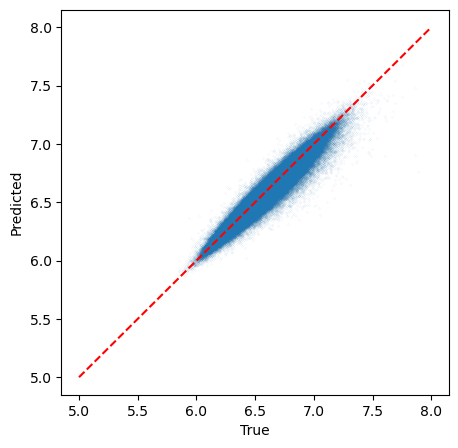

In [7]:
# Plot predictions
plt.figure(figsize=(5,5))
plt.scatter(labels.cpu().numpy(), predictions.cpu().numpy(), s=0.001)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.plot([5, 8], [5, 8], "--", color='red')
plt.show()
